In [1]:
import numpy as np
import pandas as pd
import scipy
import spacy
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
import imp
import pyLDAvis
import gc
%matplotlib inline
#pyLDAvis.enable_notebook()

# Comparing LSA, LDA, and NNMF

As in the lesson, I follow these steps to compare these three topic modeling techniques:

1. Parse and process the data into a tf-idf matrix.
2. Fit LSA, LDA, and NNMF models with 5 topics each.
3. Extract the words that best describe each topic.
4. Examine the topic relationships for the various words pertaining to the different "ground-truth" topics

The dataset for this challenge is the popular <a href='http://qwone.com/~jason/20Newsgroups/'>20 newsgroups dataset</a>. I've parsed the data, extracting various labels (most importantly, newsgroup categories) using <a href='https://github.com/AlliedToasters/nlp/blob/master/access_newsgroup_data.ipynb'>this script</a>.


## Generating the tfidf matrix

In [2]:
#Load the data from csv
#data = pd.read_csv('20_newsgroups_parse2.csv')

#Parse with spacy
parse = spacy.load('en_core_web_sm', vocab=True)
word_list = [word for word in np.load('word_list.npy')]

In [3]:
def remove_baggage(input_text):
    """Removes lines that were carried over from other texts"""
    lines = input_text.split('\n')
    result = ''
    for line in lines:
        if len(line) > 0 and line[0] != '>':
            result += ('\n' + line)
    return result

def parse_body(input_string, vocabulary=word_list, parse_function=parse, lemmatize=False):
    """Takes an input string and parsing function (built for
    spacy parser.) Cleans up resulting text and returns the
    "good stuff" without much noise (as raw string text).
    """
    try:
        parsed_input = parse_function(input_string)
    except:
        return ' '
    keepers = []
    for token in parsed_input:
        if token.is_alpha or token.orth_ == '.':
            if lemmatize:
                if token.lemma_ == '-PRON-':
                    keepers.append(token.orth_)
                else:
                    keepers.append(token.lemma_)
            else:
                keepers.append(token.orth_)
    result = ' '.join(keepers)
    global count
    count += 1
    if count % 500 == 0:
        print(count, ' documents cleaned!')
    return result

In [4]:
#Apply cleaning script, extracting raw word features and discarding punctuation
#(Excluded for brevity;takes tens of minutes to run on entire dataset)
#count = 0
#data['clean_text'] = data.body.apply(lambda x: parse_body(remove_baggage(x)))

In [5]:
#Apply same script, extracting lemmas.
#(Excluded for brevity;takes tens of minutes to run on entire dataset)
#count = 0
#data['lemmas'] = data.body.apply(lambda x: parse_body(remove_baggage(x), lemmatize=True))

In [6]:
#Checkpoint to save/load progress thus far
#data.to_csv('newsgroups_checkpoint_p2.csv', index=False)
data = pd.read_csv('newsgroups_checkpoint_p2.csv')

#A small number (< 30) of samples came up null. Too few to worry about.
data.lemmas = np.where(data.lemmas.isnull(), '', data.lemmas)

In [7]:
#split into train/test groups w/ random assignment
holdout_frac = .8
train = pd.DataFrame(columns=data.columns)
test = pd.DataFrame(columns=data.columns)
for newsgroup in data.newsgroups.unique():
    df = data[data.newsgroups==newsgroup]
    holdout = df.sample(frac=holdout_frac)
    holdin = df[~df.index.isin(holdout.index)]
    train = pd.concat([train, holdin], axis=0)
    test = pd.concat([test, holdout], axis=0)
    

In [8]:
# I use a list of words in English and sklearn's vectorizer
# to come up with a nice vocabulary for the analysis.
hasher = CountVectorizer(stop_words='english')
hasher.fit(train['lemmas'])
set_words = set(word_list)
set_vocab = set(hasher.vocabulary_.keys())
#Intersection of vectorizer tokens and English vocabulary.
vocab = set_vocab.intersection(set_words)
print('words selected for vocabulary: ', len(vocab))

words selected for vocabulary:  15482


In [9]:
# Creating the tf-idf matrix.
# Include vocabulary, exclude stop words.
vectorizer = TfidfVectorizer(stop_words='english', vocabulary=vocab)
counter = CountVectorizer(stop_words='english', vocabulary=vocab)
newsgroups_tfidf=vectorizer.fit_transform(train['lemmas'])
term_counts = counter.fit_transform(train['lemmas'])

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=20

# Linking words to topics
def word_topic(tfidf, solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 10


I've taken these functions from the tutorial in the curriculum.  The first provides a list of the words that are paired with each topic.  The second gives us the best words for each topic so we can compare across methods.

## Fitting the three topic extraction models

In [10]:
# LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
newsgroups_lsa = lsa.fit_transform(newsgroups_tfidf)

components_lsa = word_topic(newsgroups_tfidf, newsgroups_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)                


In [11]:
#Get doc lengths for pyLDAvis
doc_lengths = train.lemmas.apply(len)

In [12]:
train.newsgroups.value_counts()

rec.motorcycles             200
sci.crypt                   200
comp.os.ms-windows.misc     200
talk.politics.guns          200
talk.politics.mideast       200
talk.politics.misc          200
alt.atheism                 199
sci.electronics             199
comp.windows.x              199
talk.religion.misc          199
rec.sport.baseball          199
sci.med                     199
comp.graphics               199
misc.forsale                199
rec.sport.hockey            199
sci.space                   199
soc.religion.christian      199
rec.autos                   199
comp.sys.ibm.pc.hardware    199
comp.sys.mac.hardware       197
Name: newsgroups, dtype: int64

In [13]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=0, # Causes earlier iterations to have less influence on the learning
          max_iter=20, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=2, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0,
          learning_method='online'
         )

newsgroups_lda = lda.fit_transform(term_counts) 

components_lda = word_topic(term_counts, newsgroups_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)


In [14]:
def wrangle_data(ttd, dtd, dl, vocab, term_freq):
    """Prepares data for the pyLDAvis prepare function."""
    data = {
        'topic_term_dists': ttd, 
        'doc_topic_dists': dtd,
        'doc_lengths': dl,
        'vocab': vocab,
        'term_frequency': term_freq
    }
    return data

In [15]:
shape = components_lda.shape
lda_top_term_dist = np.array(components_lda).reshape(shape[1], shape[0])

result = wrangle_data(ttd=lda_top_term_dist, dtd=newsgroups_lda, dl=doc_lengths, vocab=terms, term_freq=np.array(term_counts.sum(axis=0)).reshape(-1))
print('Topic-Term shape: %s' % str(np.array(result['topic_term_dists']).shape))
print('Doc-Topic shape: %s' % str(np.array(result['doc_topic_dists']).shape))

Topic-Term shape: (20, 15482)
Doc-Topic shape: (3984, 20)


In [16]:
#Display vis data
vis_data = pyLDAvis.prepare(**result)
pyLDAvis.display(vis_data)

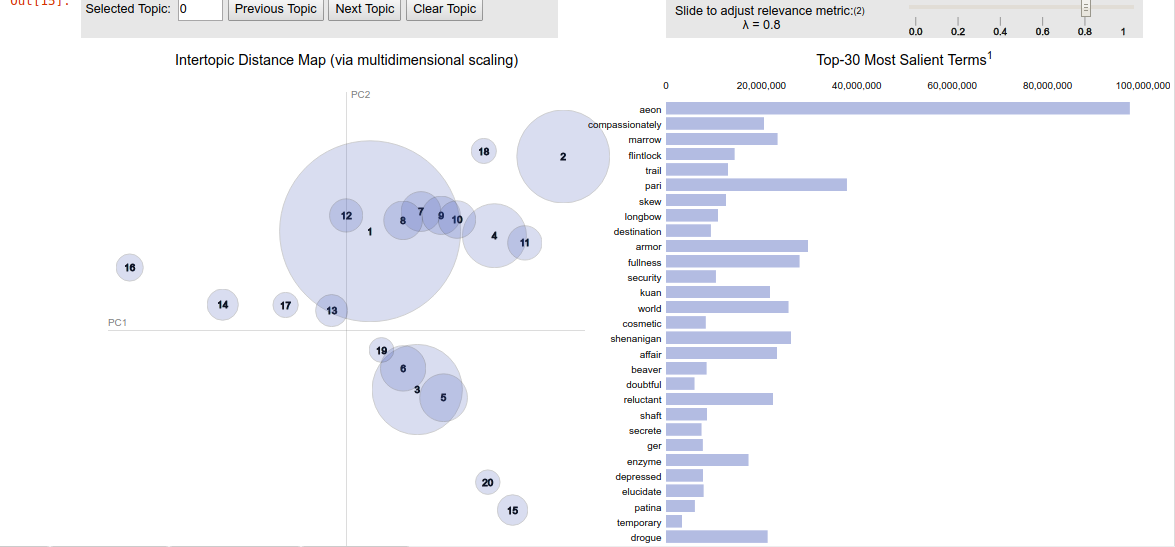

In [17]:
#Display from screenshot since interactive widget doesn't appear on Github
from IPython.display import Image
Image(filename='pyLDAvis_2.png') 

In [18]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
newsgroups_nmf = nmf.fit_transform(newsgroups_tfidf) 

components_nmf = word_topic(newsgroups_tfidf, newsgroups_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

# Inspecting the topics

For each topic, I list the ten "most-relevant" words according to each method:

In [19]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])
    

Topic 0:
             LSA           LDA             NNMF
0    write 67.73   write 87.05      people 1.83
0  article 56.38  article 60.9         gun 1.42
0      use 52.85     use 56.68  government 1.37
0     know 50.19     say 50.04       right 1.35
0      say 47.71    know 45.04         say 1.19
0     like 45.59    make 44.76       write 1.03
0     just 45.41    just 44.52         law 0.97
0    think 44.27     good 43.4       think 0.96
0     good 42.83    like 43.11        make 0.91
0   people 42.63  people 41.39         kill 0.9
Topic 1:
             LSA            LDA          NNMF
1    thank 15.88   write 142.49      use 3.43
1      use 13.65  article 96.76       run 1.8
1     file 13.41     know 90.47  program 1.62
1   window 12.39      say 84.84      work 1.4
1      card 10.2      use 75.74    write 1.16
1  program 10.19      good 73.6     like 1.14
1     drive 9.63     make 66.99  machine 1.11
1      host 9.16      god 66.51     good 1.01
1   posting 8.53    think 66.39     know

This view of our topics gives us an idea of some groupings. To my interpretation, NNMF gives the most sensible and coherent groupings that seem to line up with some of the "ground truth" topics. Pay attention to the NNMF topic #7, which clearly seems concerned with computer stuff, in the following visualizations.

# Sparsity

Now I examine sparsity by looking at the distributions of loadings for various words that I've selected that are related to the newsgroups topics. 

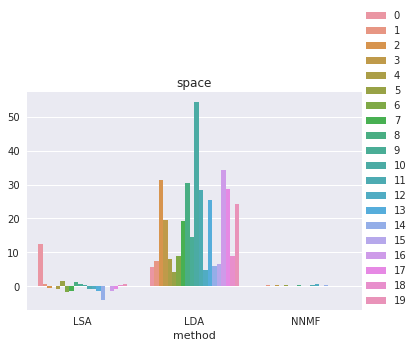

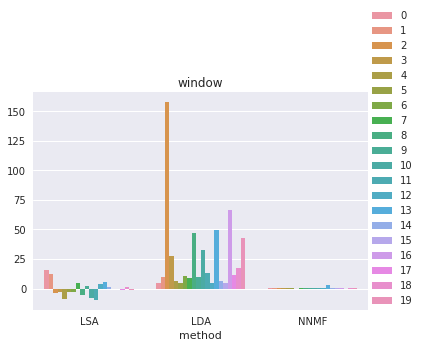

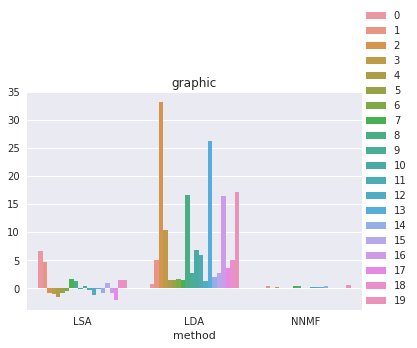

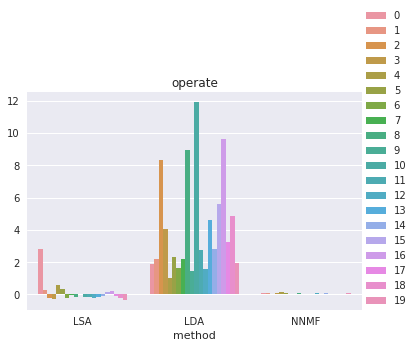

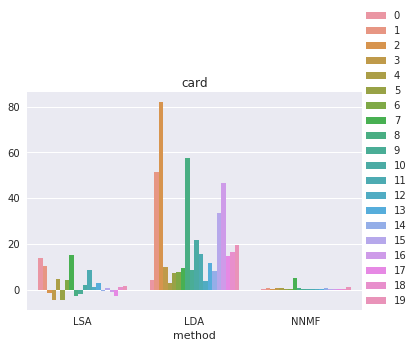

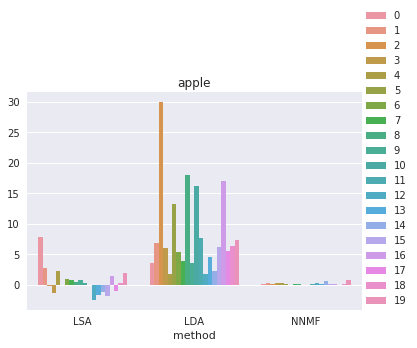

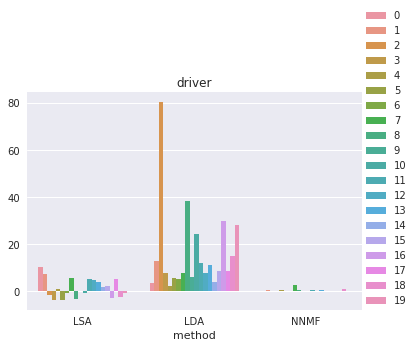

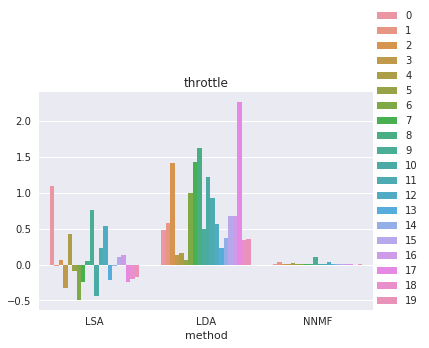

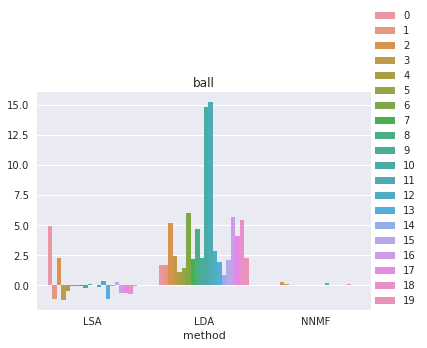

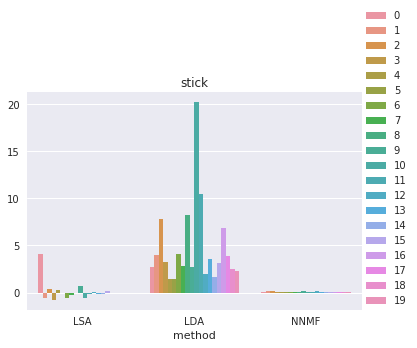

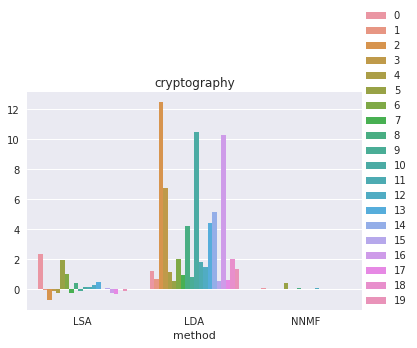

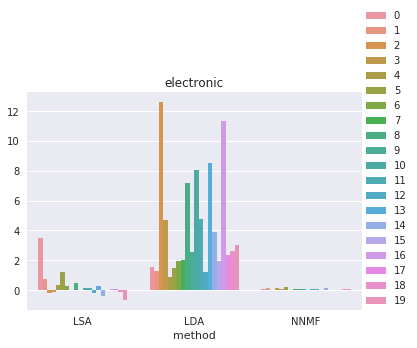

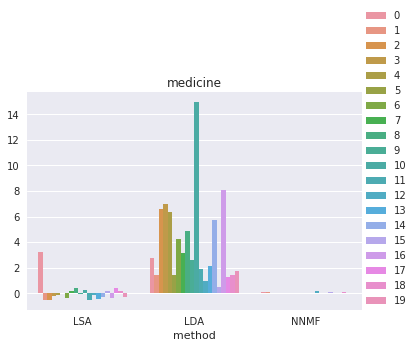

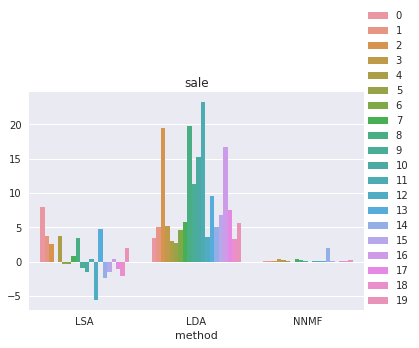

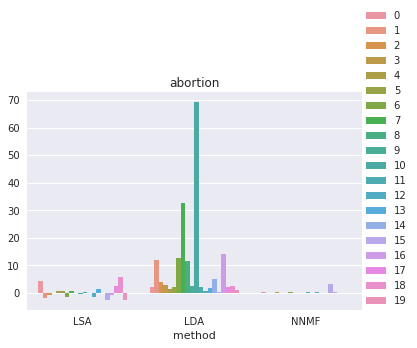

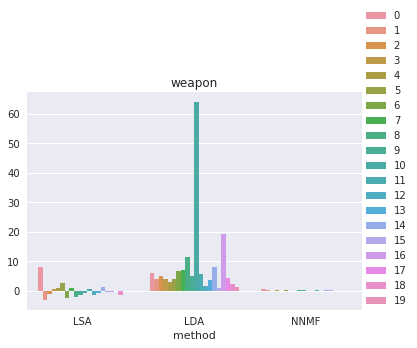

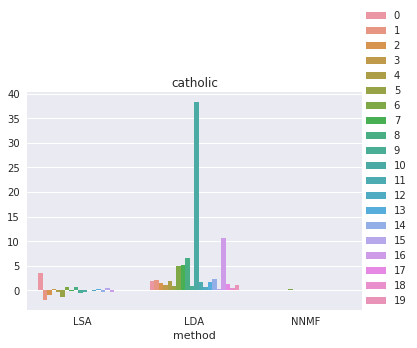

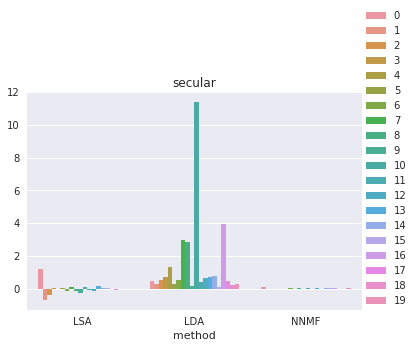

In [20]:
# The words to look at.
targetwords=[
    'space',
    'window',
    'graphic',
    'operate',
    'card',
    'apple',
    'driver',
    'throttle',
    'ball',
    'stick',
    'cryptography',
    'electronic',
    'medicine',
    'sale',
    'abortion',
    'weapon',
    'catholic',
    'secular'
]

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], ntopics, axis=0)
wordloadings['loading']=[x for x in range(ntopics)]*3

sns.set(style="darkgrid")

for word in targetwords:
    g = sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    g.legend(loc=(1,0))
    plt.ylabel("")
    plt.show()


LSA and LDA both give dominance to a select few groups, which is problematic. NNMF seems to give more sensible distributions.